In this notebook, I have attempted to figure out what a CNN or ANN thinks, a perfect image of a particular digit is. This has been done by first training a CNN on MNSIT and then using gradient to reshape a noisy meaningless image into the one that the neural net thinks is the perfect digit.
The gradient moves in the direction of reduction of loss with respect to all the dimensions of the image. The process is gradient ascent, as the goal is to maximize the class score, or minimize the negative score(loss). The raw output of the neural nets (the logits) is converted into probablities.

We will also be comparing what ANN sees vs what more complex structures like CNN see

Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set the device to use for training and inference
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


The L2 regularization term is important for preventing extreme pixel values and encouraging smoother, more interpretable images

In [20]:
from math import log10
import sys
max_size_limit = sys.maxsize
print(max_size_limit)
print(log10(max_size_limit))

# Training Hyperparameters
BATCH_SIZE = 1024
EPOCHS = 15
LEARNING_RATE_MODEL = 0.001

# Visualization Hyperparameters
VIZ_LEARNING_RATE = 0.1
L2_REG_LAMBDA = 0.005 # Regularization to prevent noisy images


MAX_VIZ_ITERATIONS = int(max_size_limit)  # Safeguard against infinite loops
PATIENCE = 4000            # Steps to wait for improvement before stopping
TOLERANCE = 0          # Minimum change in loss to be considered an improvement

9223372036854775807
18.964889726830815


Defining our CNN and ANN

In [3]:
class PCNN(nn.Module):
    def __init__(self):
        super(PCNN, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.MaxPool2d(2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.MaxPool2d(2)
        )
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, 10)
        )
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        return self.fc_block(x)

class SANN(nn.Module):
    def __init__(self):
        super(SANN, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 512), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 10)
        )
    def forward(self, x):
        return self.layers(x)

In [4]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

def train_model(model, model_name):

    print(f"--- Training {model_name} ---")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE_MODEL)

    for epoch in range(EPOCHS):
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        print(f"  Epoch {epoch+1}/{EPOCHS} complete.")
    print(f"Training for {model_name} finished.\n")
    return model

# Instantiate and train the CNN
cnn_model = train_model(PCNN(), "Powerful CNN")

# Instantiate and train the ANN
ann_model = train_model(SANN(), "Simple ANN")

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 498kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.56MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.58MB/s]


--- Training Powerful CNN ---
  Epoch 1/15 complete.
  Epoch 2/15 complete.
  Epoch 3/15 complete.
  Epoch 4/15 complete.
  Epoch 5/15 complete.
  Epoch 6/15 complete.
  Epoch 7/15 complete.
  Epoch 8/15 complete.
  Epoch 9/15 complete.
  Epoch 10/15 complete.
  Epoch 11/15 complete.
  Epoch 12/15 complete.
  Epoch 13/15 complete.
  Epoch 14/15 complete.
  Epoch 15/15 complete.
Training for Powerful CNN finished.

--- Training Simple ANN ---
  Epoch 1/15 complete.
  Epoch 2/15 complete.
  Epoch 3/15 complete.
  Epoch 4/15 complete.
  Epoch 5/15 complete.
  Epoch 6/15 complete.
  Epoch 7/15 complete.
  Epoch 8/15 complete.
  Epoch 9/15 complete.
  Epoch 10/15 complete.
  Epoch 11/15 complete.
  Epoch 12/15 complete.
  Epoch 13/15 complete.
  Epoch 14/15 complete.
  Epoch 15/15 complete.
Training for Simple ANN finished.



In [5]:
def visualize_representation(model, target_class):
    """Performs gradient ascent on the input image pixels until convergence."""
    model.eval()
    img_to_optimize = nn.Parameter(torch.rand(1, 1, 28, 28, device=device) * 0.2 + 0.4)
    optimizer = optim.Adam([img_to_optimize], lr=VIZ_LEARNING_RATE)

    best_loss = float('inf')
    patience_counter = 0

    for i in range(MAX_VIZ_ITERATIONS):
        optimizer.zero_grad()
        output = model(img_to_optimize)

        class_score_loss = -output[0, target_class]
        l2_reg_loss = L2_REG_LAMBDA * torch.norm(img_to_optimize)
        total_loss = class_score_loss + l2_reg_loss

        total_loss.backward()
        optimizer.step()

        with torch.no_grad():
            img_to_optimize.clamp_(0, 1)

        current_loss = total_loss.item()
        if best_loss - current_loss > TOLERANCE:
            best_loss = current_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE:
            break

    return img_to_optimize.detach().cpu().squeeze().numpy()

The top row is the real example, the middle one is how the CNN thinks, and the last one is what the ANN percieves

--- Generating visualizations for both models ---
CNN visualizations complete.
ANN visualizations complete.


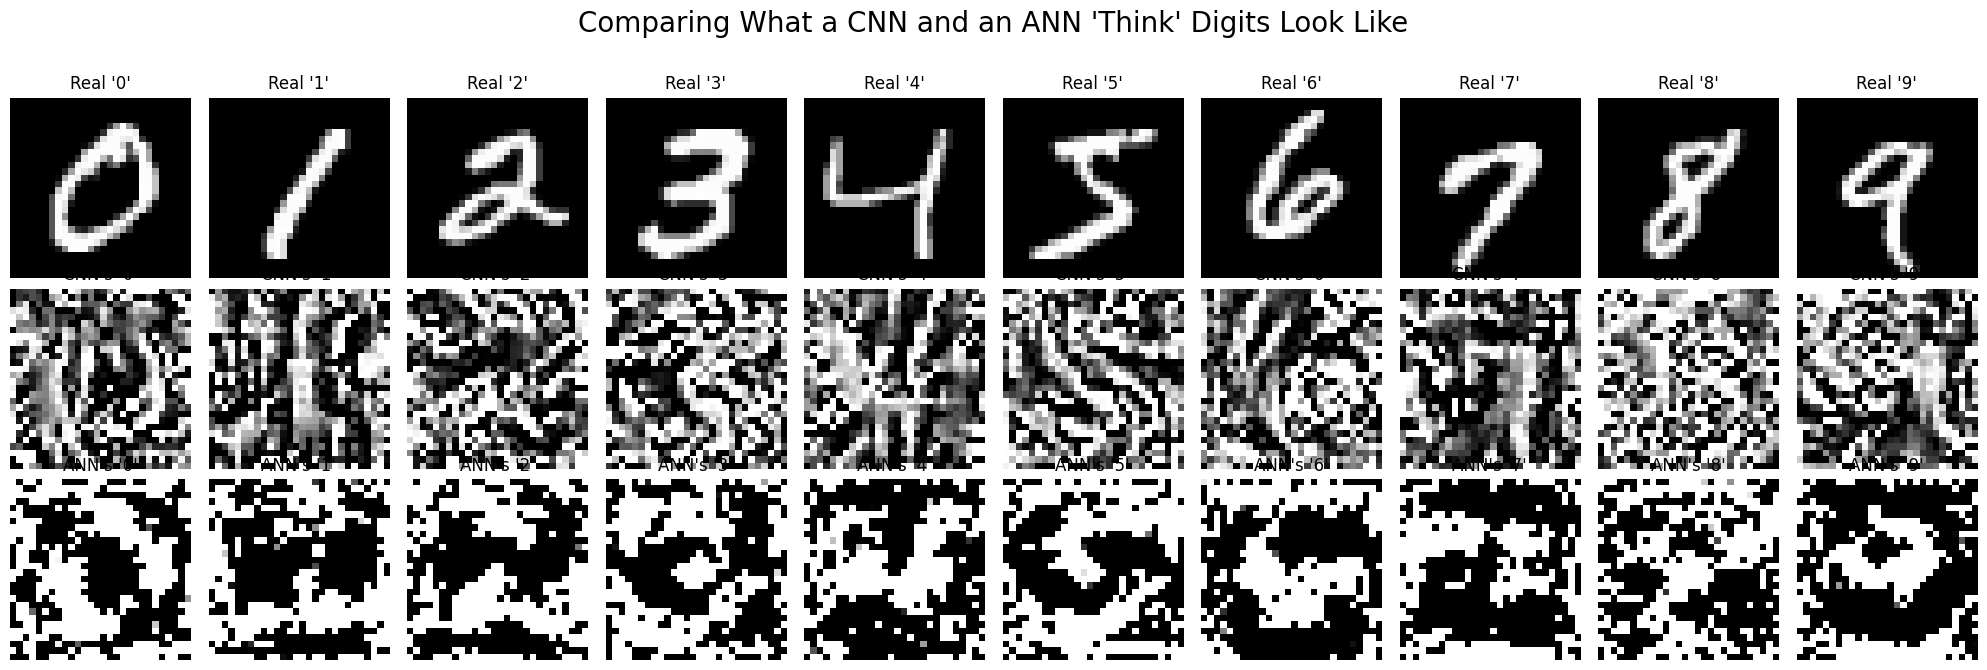

In [21]:
print("--- Generating visualizations for both models ---")

# Get one real image for each class for comparison. Just for comparision, these real images have no direct relation to the views of neural nets
real_images = {i: None for i in range(10)}
for img, label in train_dataset:
    if real_images[label] is None:
        real_images[label] = img.squeeze().numpy()
    if all(v is not None for v in real_images.values()):
        break

# Generate the representations
cnn_reps = {i: visualize_representation(cnn_model, i) for i in range(10)}
print("CNN visualizations complete.")
ann_reps = {i: visualize_representation(ann_model, i) for i in range(10)}
print("ANN visualizations complete.")

# Plotting the comparison
fig, axes = plt.subplots(3, 10, figsize=(20, 7))
fig.suptitle("Comparing What a CNN and an ANN 'Think' Digits Look Like", fontsize=20)

for i in range(10):
    # Real Digits
    axes[0, i].imshow(real_images[i], cmap='gray')
    axes[0, i].set_title(f"Real '{i}'")
    axes[0, i].axis('off')

    # CNN Representations
    axes[1, i].imshow(cnn_reps[i], cmap='gray')
    axes[1, i].set_title(f"CNN's '{i}'")
    axes[1, i].axis('off')

    # ANN Representations
    axes[2, i].imshow(ann_reps[i], cmap='gray')
    axes[2, i].set_title(f"ANN's '{i}'")
    axes[2, i].axis('off')

axes[0, 0].set_ylabel("Real Example", rotation=90, labelpad=20, fontsize=14, ha='center', va='center')
axes[1, 0].set_ylabel("CNN Vision", rotation=90, labelpad=20, fontsize=14, ha='center', va='center')
axes[2, 0].set_ylabel("ANN Vision", rotation=90, labelpad=20, fontsize=14, ha='center', va='center')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

he final image compares a real digit (top), the CNN's vision (middle), and the ANN's perception (bottom).
The results are clear. The CNN has learned the essential spatial features of the digits, like the curves of a '3' or the lines of a '7'. Its representation of an '8', however, is the least recognizable, appearing more as a noisy texture than two distinct loops.
In stark contrast, the ANN's vision is a chaotic pixel template, proving it has no understanding of shape or structure. This experiment visually confirms that CNNs learn the concepts behind images, while ANNs remain spatially blind.
The pov of ANN also looks like it got hold of the average brightness of the pixels

Loading test data for full failure analysis...

Searching for all failure cases for Powerful CNN...
-> Found 78 misclassified images out of 10000 for the Powerful CNN.


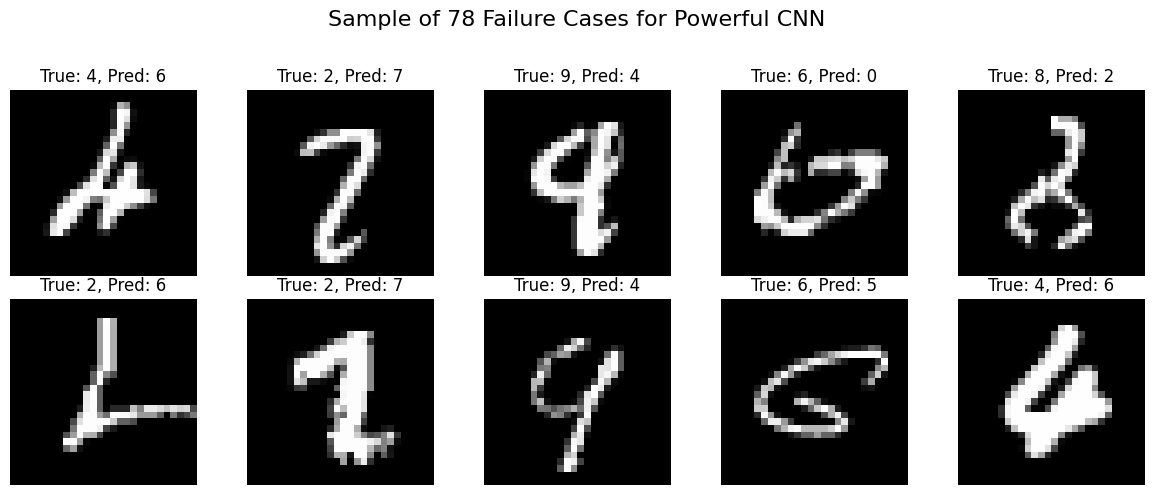


Searching for all failure cases for Simple ANN...
-> Found 192 misclassified images out of 10000 for the Simple ANN.


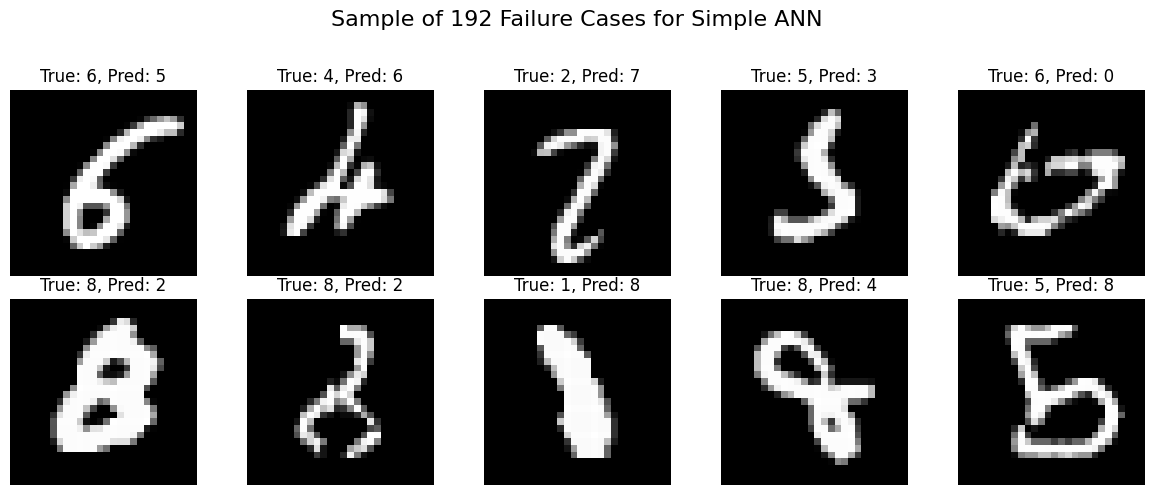

In [25]:

print("Loading test data for full failure analysis...")
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
# Use a large batch size for efficient evaluation
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
# ---------------------------------------------------------


def find_all_failures_and_plot_sample(model, model_name, test_loader, device, num_to_plot=10):

    model.eval()
    all_failures = []

    # Iterate through the entire test dataset to find all misclassified examples
    print(f"\nSearching for all failure cases for {model_name}...")
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)

            # Get the indices of incorrect predictions within the current batch
            mismatched_idxs = (pred.view_as(target) != target).nonzero(as_tuple=True)[0]

            # Append all found failures to our list
            for idx in mismatched_idxs:
                all_failures.append({
                    'image': data[idx].cpu(),
                    'true_label': target[idx].cpu().item(),
                    'pred_label': pred[idx].cpu().item()
                })

    print(f"-> Found {len(all_failures)} misclassified images out of {len(test_dataset)} for the {model_name}.")

    # Plot a sample of the collected failures
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    fig.suptitle(f'Sample of {len(all_failures)} Failure Cases for {model_name}', fontsize=16)
    for i, ax in enumerate(axes.flat):
        if i < len(all_failures) and i < num_to_plot:
            case = all_failures[i]
            ax.imshow(case['image'].squeeze(), cmap='gray')
            ax.set_title(f"True: {case['true_label']}, Pred: {case['pred_label']}")
            ax.axis('off')
        else:
            ax.axis('off') # Hide unused subplots
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Assuming 'cnn_model', 'ann_model', and 'device' are already defined
# and available in the notebook's memory from previous cells.

# Show failure cases for the CNN across the entire dataset
find_all_failures_and_plot_sample(cnn_model, "Powerful CNN", test_loader, device)

# Show failure cases for the ANN across the entire dataset
find_all_failures_and_plot_sample(ann_model, "Simple ANN", test_loader, device)

Loading test data for confusion matrix analysis...

--- Analyzing Powerful CNN ---


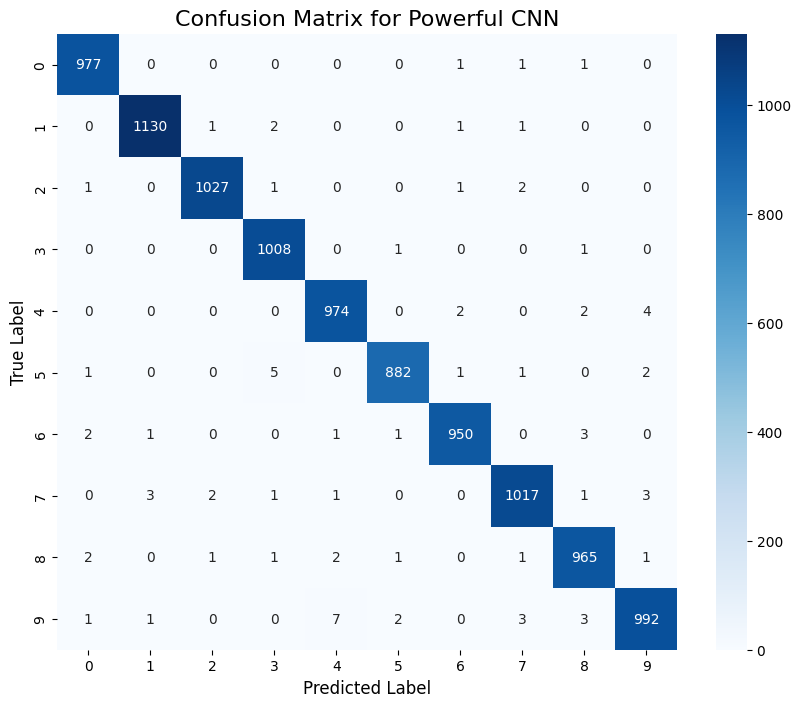

Top 3 Misclassification Pairs for Powerful CNN:
  1. Predicted '4' but was actually '9' (7 times).
  2. Predicted '3' but was actually '5' (5 times).
  3. Predicted '9' but was actually '4' (4 times).
  4. Predicted '8' but was actually '6' (3 times).
  5. Predicted '1' but was actually '7' (3 times).
  6. Predicted '9' but was actually '7' (3 times).
  7. Predicted '7' but was actually '9' (3 times).
  8. Predicted '8' but was actually '9' (3 times).
  9. Predicted '3' but was actually '1' (2 times).
  10. Predicted '7' but was actually '2' (2 times).

--- Analyzing Simple ANN ---


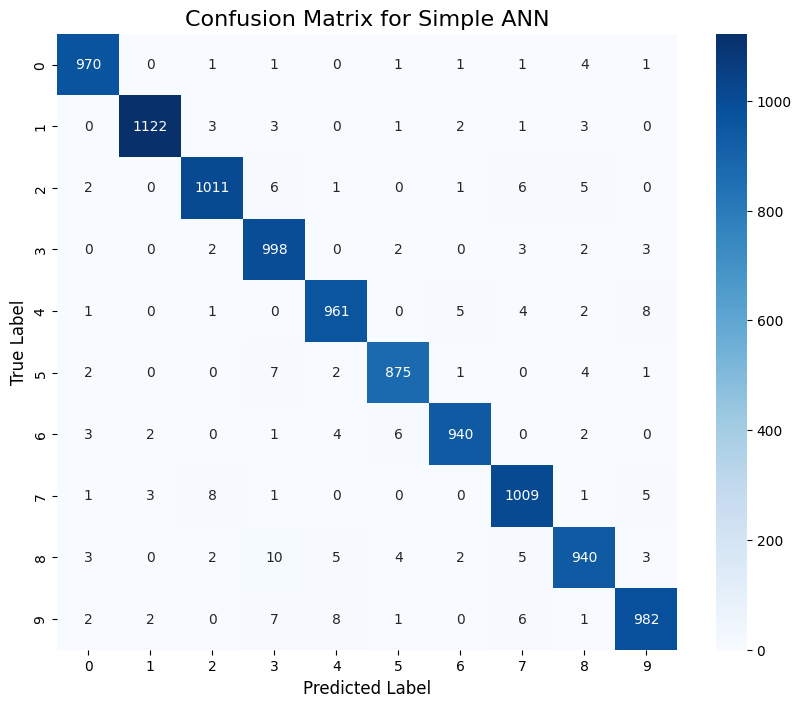

Top 3 Misclassification Pairs for Simple ANN:
  1. Predicted '3' but was actually '8' (10 times).
  2. Predicted '9' but was actually '4' (8 times).
  3. Predicted '2' but was actually '7' (8 times).
  4. Predicted '4' but was actually '9' (8 times).
  5. Predicted '3' but was actually '5' (7 times).
  6. Predicted '3' but was actually '9' (7 times).
  7. Predicted '3' but was actually '2' (6 times).
  8. Predicted '7' but was actually '2' (6 times).
  9. Predicted '5' but was actually '6' (6 times).
  10. Predicted '7' but was actually '9' (6 times).


In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

print("Loading test data for confusion matrix analysis...")
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
# ---------------------------------------------------------


def analyze_and_plot_confusion_matrix(model, model_name, test_loader, device):

    model.eval()
    all_true_labels = []
    all_pred_labels = []

    print(f"\n--- Analyzing {model_name} ---")
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)

            all_true_labels.extend(target.cpu().numpy())
            all_pred_labels.extend(pred.cpu().numpy())

    # Calculate the confusion matrix
    cm = confusion_matrix(all_true_labels, all_pred_labels)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(f'Confusion Matrix for {model_name}', fontsize=16)
    plt.show()


    error_matrix = cm.copy()
    np.fill_diagonal(error_matrix, 0)

    print(f"Top 3 Misclassification Pairs for {model_name}:")
    for i in range(10):
        # Find the location of the largest error
        max_error_idx = np.unravel_index(np.argmax(error_matrix), error_matrix.shape)
        true_label, pred_label = max_error_idx
        error_count = error_matrix[true_label, pred_label]

        if error_count == 0:
            break # Stop if there are no more errors

        print(f"  {i+1}. Predicted '{pred_label}' but was actually '{true_label}' ({error_count} times).")


        error_matrix[true_label, pred_label] = 0




analyze_and_plot_confusion_matrix(cnn_model, "Powerful CNN", test_loader, device)

analyze_and_plot_confusion_matrix(ann_model, "Simple ANN", test_loader, device)

From the above EDA, it becomes clear how the CNN clearly outperfoms ANN by understanding the structures of images well. The images where CNN has failed are also the images which could be difficult for humans to classify as well, whereas this is not the case for the ANNs.
The most confusing digits have been 9 and 4 for both the neural nets, they are very similar as well.